# Clasificación de Tumores Mamarios con SVM - CBIS-DDSM

Este notebook utiliza los archivos de entrada (`train_split.parquet`, `val_split.parquet`, `test_split.parquet`), para implementar un modelo **SVM (Máquinas de Vectores de Soporte)**

In [2]:
# Librerías necesarias
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
!pip install pyarrow

#### verificando que features existen en los archivos: test_features.parquet, val_features.parquet, train_features.parquet

In [4]:
import pandas as pd

# Definir la ruta base
ruta_base = "/Users/clubability/Documents/SVM con 7 features/dataset clean"

# Cargar los archivos
train_features = pd.read_parquet(f"{ruta_base}/train_features.parquet")
val_features = pd.read_parquet(f"{ruta_base}/val_features.parquet")
test_features = pd.read_parquet(f"{ruta_base}/test_features.parquet")

# Mostrar las cabeceras
print("Train features:")
display(train_features.head())

print("\n Validation features:")
display(val_features.head())

print("\n Test features:")
display(test_features.head())

# Mostrar columnas disponibles
print("\n Columnas en train_features:")
print(train_features.columns.tolist())


Train features:


,image_path,cropped_path,roi_path,abnormality type,assessment,breast_density,calc distribution,calc type,image view,left or right breast,...,pathology,image_path_exists,cropped_path_exists,roi_path_exists,full_image_path,exists,mean_intensity,std_intensity,width,height
0,Mass-Test_P_01395_RIGHT_MLO/1.3.6.1.4.1.9590.1...,Mass-Test_P_01395_RIGHT_MLO_1/1.3.6.1.4.1.9590...,Mass-Test_P_01395_RIGHT_MLO_1/1.3.6.1.4.1.9590...,mass,3,1,None,None,MLO,RIGHT,...,BENIGN,False,False,False,D:\TFM_CBIS\images\CBIS-DDSM\Mass-Test_P_01395...,True,0.276493,0.255702,2968,4712
1,Mass-Test_P_01110_RIGHT_CC/1.3.6.1.4.1.9590.10...,Mass-Test_P_01110_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_01110_RIGHT_CC_1/1.3.6.1.4.1.9590....,mass,5,4,None,None,CC,RIGHT,...,MALIGNANT,False,False,False,D:\TFM_CBIS\images\CBIS-DDSM\Mass-Test_P_01110...,True,0.177803,0.250622,4051,6871
2,Mass-Training_P_00401_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00401_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00401_LEFT_MLO_1/1.3.6.1.4.1.9...,mass,3,2,None,None,MLO,LEFT,...,BENIGN,False,False,False,D:\TFM_CBIS\images\CBIS-DDSM\Mass-Training_P_0...,True,0.225781,0.255833,3560,5792
3,Calc-Test_P_01845_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_01845_RIGHT_CC_1/1.3.6.1.4.1.9590....,Calc-Test_P_01845_RIGHT_CC_1/1.3.6.1.4.1.9590....,calcification,4,2,CLUSTERED,PLEOMORPHIC,CC,RIGHT,...,BENIGN,False,False,False,D:\TFM_CBIS\images\CBIS-DDSM\Calc-Test_P_01845...,True,0.181317,0.239942,2506,4591
4,Mass-Training_P_01557_RIGHT_CC/1.3.6.1.4.1.959...,Mass-Training_P_01557_RIGHT_CC_1/1.3.6.1.4.1.9...,Mass-Training_P_01557_RIGHT_CC_1/1.3.6.1.4.1.9...,mass,3,4,None,None,CC,RIGHT,...,BENIGN,False,False,False,D:\TFM_CBIS\images\CBIS-DDSM\Mass-Training_P_0...,True,0.243918,0.302651,2356,4531



 Validation features:


,image_path,cropped_path,roi_path,abnormality type,assessment,breast_density,calc distribution,calc type,image view,left or right breast,...,pathology,image_path_exists,cropped_path_exists,roi_path_exists,full_image_path,exists,mean_intensity,std_intensity,width,height
0,Calc-Training_P_01569_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_01569_RIGHT_CC_2/1.3.6.1.4.1.9...,Calc-Training_P_01569_RIGHT_CC_2/1.3.6.1.4.1.9...,calcification,4,4,CLUSTERED,PUNCTATE-AMORPHOUS,CC,RIGHT,...,BENIGN,False,False,False,D:\TFM_CBIS\images\CBIS-DDSM\Calc-Training_P_0...,True,0.100049,0.203093,3032,4648
1,Calc-Training_P_00852_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00852_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00852_LEFT_CC_1/1.3.6.1.4.1.95...,calcification,4,4,CLUSTERED,PLEOMORPHIC,CC,LEFT,...,MALIGNANT,False,False,False,D:\TFM_CBIS\images\CBIS-DDSM\Calc-Training_P_0...,True,0.250439,0.260817,3901,5596
2,Calc-Training_P_00425_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00425_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00425_RIGHT_MLO_1/1.3.6.1.4.1....,calcification,2,1,CLUSTERED,COARSE-PLEOMORPHIC,MLO,RIGHT,...,BENIGN,False,False,False,D:\TFM_CBIS\images\CBIS-DDSM\Calc-Training_P_0...,True,0.136949,0.196653,3976,5728
3,Calc-Training_P_00471_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00471_LEFT_CC_2/1.3.6.1.4.1.95...,Calc-Training_P_00471_LEFT_CC_2/1.3.6.1.4.1.95...,calcification,2,3,N/A,VASCULAR-COARSE,CC,LEFT,...,BENIGN_WITHOUT_CALLBACK,False,False,False,D:\TFM_CBIS\images\CBIS-DDSM\Calc-Training_P_0...,True,0.304826,0.290419,3072,4688
4,Calc-Training_P_00471_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00471_LEFT_CC_2/1.3.6.1.4.1.95...,Calc-Training_P_00471_LEFT_CC_2/1.3.6.1.4.1.95...,calcification,2,3,N/A,VASCULAR-COARSE,CC,LEFT,...,BENIGN_WITHOUT_CALLBACK,False,False,False,D:\TFM_CBIS\images\CBIS-DDSM\Calc-Training_P_0...,True,0.304826,0.290419,3072,4688



 Test features:


,image_path,cropped_path,roi_path,abnormality type,assessment,breast_density,calc distribution,calc type,image view,left or right breast,...,pathology,image_path_exists,cropped_path_exists,roi_path_exists,full_image_path,exists,mean_intensity,std_intensity,width,height
0,Mass-Training_P_01142_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_01142_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_01142_RIGHT_MLO_1/1.3.6.1.4.1....,mass,3,2,None,None,MLO,RIGHT,...,BENIGN_WITHOUT_CALLBACK,False,False,False,D:\TFM_CBIS\images\CBIS-DDSM\Mass-Training_P_0...,True,0.171137,0.219140,2896,4504
1,Calc-Training_P_00220_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00220_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00220_LEFT_CC_1/1.3.6.1.4.1.95...,calcification,4,3,CLUSTERED,PLEOMORPHIC,CC,LEFT,...,BENIGN,False,False,False,D:\TFM_CBIS\images\CBIS-DDSM\Calc-Training_P_0...,True,0.181426,0.242956,3556,5821
2,Calc-Training_P_01691_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_01691_RIGHT_CC_3/1.3.6.1.4.1.9...,Calc-Training_P_01691_RIGHT_CC_3/1.3.6.1.4.1.9...,calcification,2,3,N/A,ROUND_AND_REGULAR-LUCENT_CENTERED,CC,RIGHT,...,BENIGN_WITHOUT_CALLBACK,False,False,False,D:\TFM_CBIS\images\CBIS-DDSM\Calc-Training_P_0...,True,0.065731,0.159688,2912,4632
3,Mass-Training_P_00146_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00146_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00146_RIGHT_MLO_1/1.3.6.1.4.1....,mass,5,1,None,None,MLO,RIGHT,...,MALIGNANT,False,False,False,D:\TFM_CBIS\images\CBIS-DDSM\Mass-Training_P_0...,True,0.145576,0.230362,3600,5904
4,Calc-Training_P_01321_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_01321_RIGHT_MLO_3/1.3.6.1.4.1....,Calc-Training_P_01321_RIGHT_MLO_3/1.3.6.1.4.1....,calcification,5,1,CLUSTERED-LINEAR,FINE_LINEAR_BRANCHING,MLO,RIGHT,...,MALIGNANT,False,False,False,D:\TFM_CBIS\images\CBIS-DDSM\Calc-Training_P_0...,True,0.288693,0.303531,3112,4776



 Columnas en train_features:
['image_path', 'cropped_path', 'roi_path', 'abnormality type', 'assessment', 'breast_density', 'calc distribution', 'calc type', 'image view', 'left or right breast', 'mass margins', 'mass shape', 'subtlety', 'type', 'pathology', 'image_path_exists', 'cropped_path_exists', 'roi_path_exists', 'full_image_path', 'exists', 'mean_intensity', 'std_intensity', 'width', 'height']


### Celda para inspeccionar tipo de dato de cada feature

In [5]:
import pandas as pd

# Ruta local a tu dataset
ruta_base = "/Users/clubability/Documents/SVM con 7 features/dataset clean"

# Cargar archivo de entrenamiento
train_features = pd.read_parquet(f"{ruta_base}/train_features.parquet")

# Lista de los 7 features
features_usar = [
    "mean_intensity",
    "std_intensity",
    "width",
    "height",
    "assessment",
    "breast_density",
    "subtlety"
]

# Mostrar tipo de dato y valores únicos por feature
for feature in features_usar:
    print(f"Feature: {feature}")
    print("Tipo de dato:", train_features[feature].dtype)
    print("Valores únicos (primeros 10):", train_features[feature].unique()[:10])
    print("-" * 50)


Feature: mean_intensity
Tipo de dato: float32
Valores únicos (primeros 10): [0.27649295 0.17780286 0.22578062 0.18131712 0.2439181  0.18151662
 0.156277   0.23517795 0.09983147 0.16313621]
--------------------------------------------------
Feature: std_intensity
Tipo de dato: float32
Valores únicos (primeros 10): [0.25570193 0.25062153 0.25583294 0.23994246 0.30265105 0.22831237
 0.15634982 0.2666778  0.19026154 0.26763454]
--------------------------------------------------
Feature: width
Tipo de dato: int64
Valores únicos (primeros 10): [2968 4051 3560 2506 2356 3728 3571 2896 2936 3056]
--------------------------------------------------
Feature: height
Tipo de dato: int64
Valores únicos (primeros 10): [4712 6871 5792 4591 4531 5760 5056 5461 4544 4496]
--------------------------------------------------
Feature: assessment
Tipo de dato: int32
Valores únicos (primeros 10): [3 5 4 2 0 1]
--------------------------------------------------
Feature: breast_density
Tipo de dato: int32
Valor

### Crear la variable objetivo `pathology_label`

#### En esta celda convertimos la columna `pathology` (que contiene etiquetas como "MALIGNANT", "BENIGN", etc.) en una versión numérica llamada `pathology_label`, que será utilizada como variable objetivo (`y`) para entrenar el modelo SVM.


In [6]:
# Crear la columna numérica 'pathology_label' a partir de la etiqueta original
mapeo = {
    'BENIGN_WITHOUT_CALLBACK': 0,
    'BENIGN': 1,
    'MALIGNANT': 2
}

train_features['pathology_label'] = train_features['pathology'].map(mapeo)
val_features['pathology_label'] = val_features['pathology'].map(mapeo)
test_features['pathology_label'] = test_features['pathology'].map(mapeo)


### Filtrar solo los 7 features seleccionados y separar `X` e `y`

#### Aquí seleccionamos únicamente las 7 variables predictoras (features) que queremos usar para entrenar el modelo. Luego separamos `X` (las features) e `y` (la etiqueta objetivo).


In [7]:
# Seleccionar los 7 features relevantes
features_usar = [
    "mean_intensity",
    "std_intensity",
    "width",
    "height",
    "assessment",
    "breast_density",
    "subtlety"
]

# Separar features (X) y variable objetivo (y)
X_train = train_features[features_usar].copy()
X_val = val_features[features_usar].copy()
X_test = test_features[features_usar].copy()

y_train = train_features["pathology_label"]
y_val = val_features["pathology_label"]
y_test = test_features["pathology_label"]


## Análisis Exploratorio de Datos (EDA)
#### Exploramos las correlaciones entre variables y la distribución por clase.

### Matriz de correlación entre los features y la clase `pathology_label`

Este gráfico muestra la matriz de correlación de Pearson entre los 7 features seleccionados y la variable objetivo `pathology_label`, la cual representa la clase de la lesión codificada numéricamente (0 = BENIGN_WITHOUT_CALLBACK, 1 = BENIGN, 2 = MALIGNANT).

Este análisis permite:

- Identificar relaciones lineales entre los features.
- Evaluar la fuerza de asociación entre cada variable predictora y la clase.
- Detectar posibles redundancias entre variables (por alta correlación entre ellas).

Cuanto mayor sea el valor absoluto de la correlación con `pathology_label`, mayor potencial tendrá el feature como predictor.


In [8]:
# Define la lista de tus 7 features como features_usar
features_usar = [
    "mean_intensity",
    "std_intensity",
    "width",
    "height",
    "assessment",
    "breast_density",
    "subtlety"
]

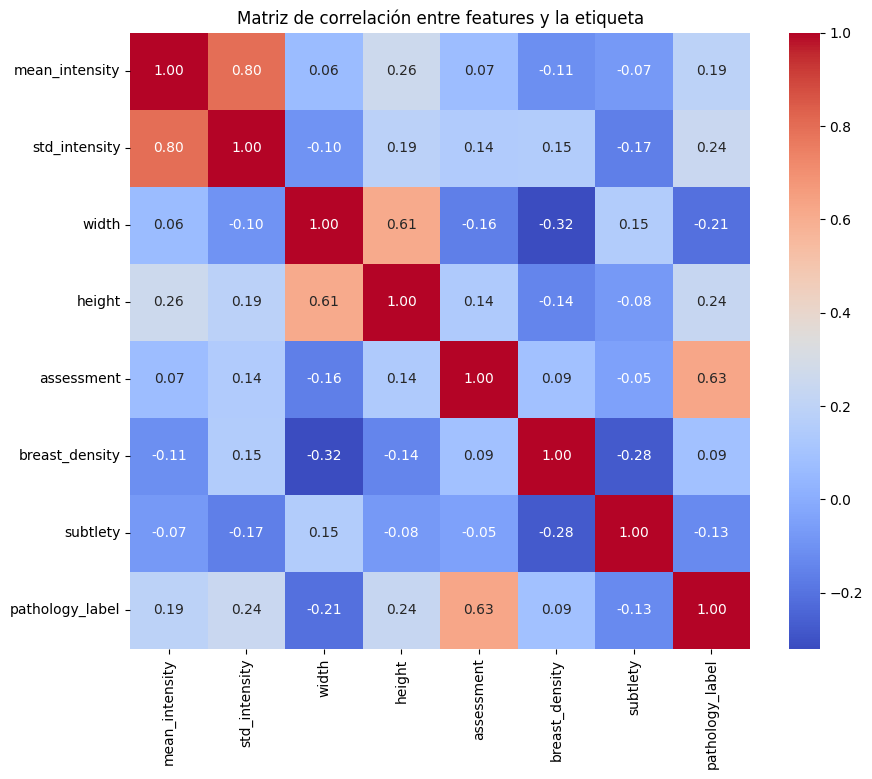

In [16]:
# Matriz de correlación
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
corr = train_features[features_usar + ['pathology_label']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación entre features y la etiqueta")
plt.show()

### Análisis de la distribución de los features según la clase `pathology_label`

En esta sección se utilizan boxplots para visualizar cómo varían los valores de cada feature (visual o clínico) en función de la clase de la lesión (`pathology_label`).

Esto permite detectar:
- Diferencias en la distribución por clase.
- Outliers o valores extremos.
- Features con potencial poder discriminativo para el modelo.

Cada gráfico compara la distribución de un feature frente a las clases:
- `0 = BENIGN_WITHOUT_CALLBACK`
- `1 = BENIGN`
- `2 = MALIGNANT`

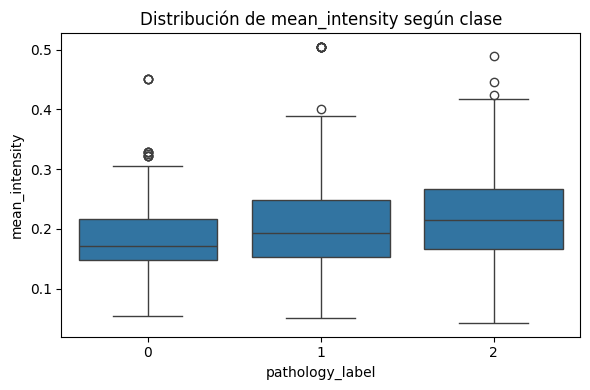

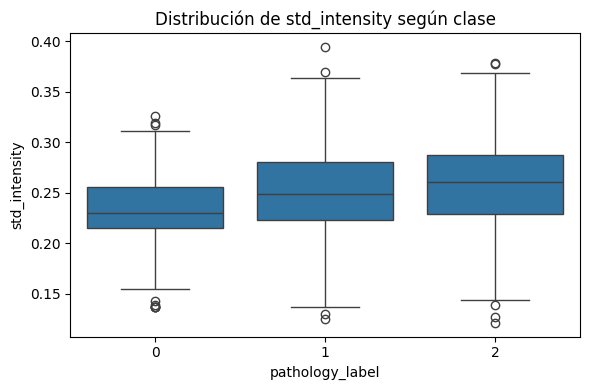

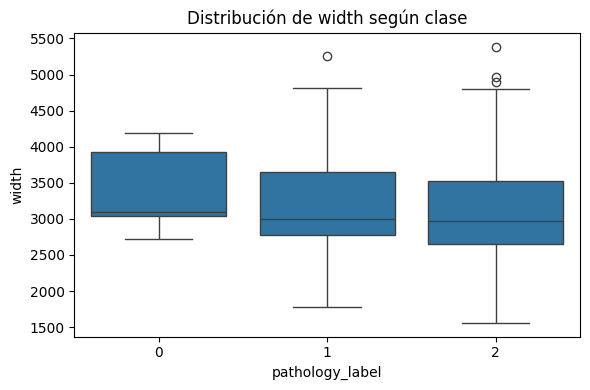

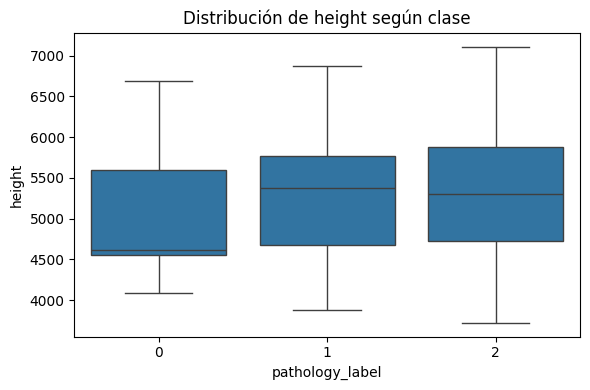

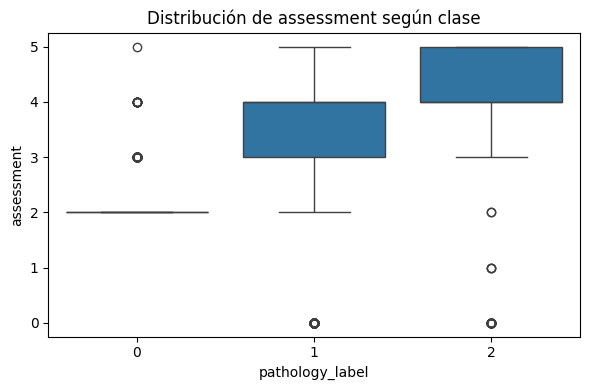

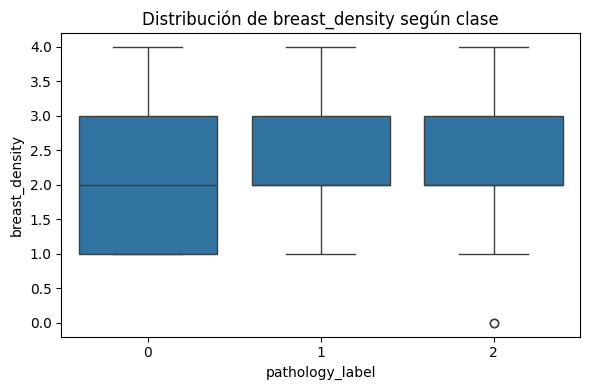

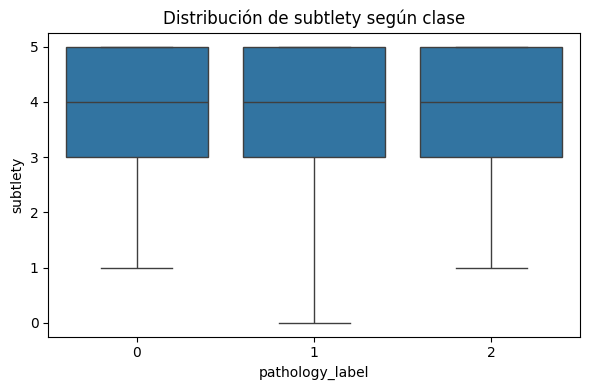

In [17]:
for col in features_usar:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='pathology_label', y=col, data=train_features)
    plt.title(f"Distribución de {col} según clase")
    plt.xlabel("pathology_label")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

### Visualización de imágenes médicas DICOM

Este bloque permite recorrer automáticamente las primeras imágenes del dataset CBIS-DDSM en formato DICOM.

Se muestran ejemplos de mamografías reales cargadas con `pydicom`, lo cual es útil para:

- Validar que las rutas estén bien construidas.
- Observar diferencias visuales entre clases.
- Comprender las dimensiones y calidad de las imágenes.

Esta etapa corresponde a la fase de exploración visual del dataset, previa al modelado.


Archivo encontrado: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Calc-Training_P_00991_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.197679650210465644301111522573998527663/1.3.6.1.4.1.9590.100.1.2.115467132111304335901137916233667214569/1-2.dcm


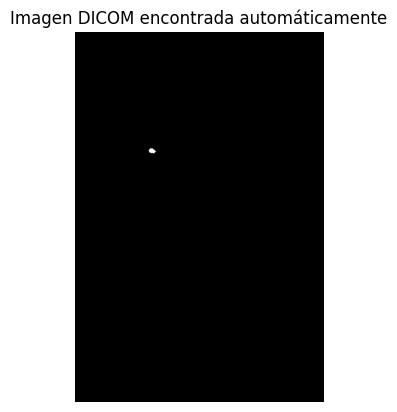


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Calc-Training_P_00991_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.197679650210465644301111522573998527663/1.3.6.1.4.1.9590.100.1.2.115467132111304335901137916233667214569/1-2.dcm


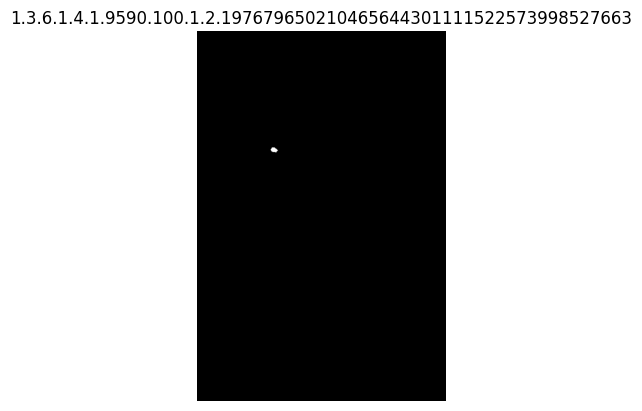


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Calc-Training_P_00991_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.197679650210465644301111522573998527663/1.3.6.1.4.1.9590.100.1.2.115467132111304335901137916233667214569/1-1.dcm


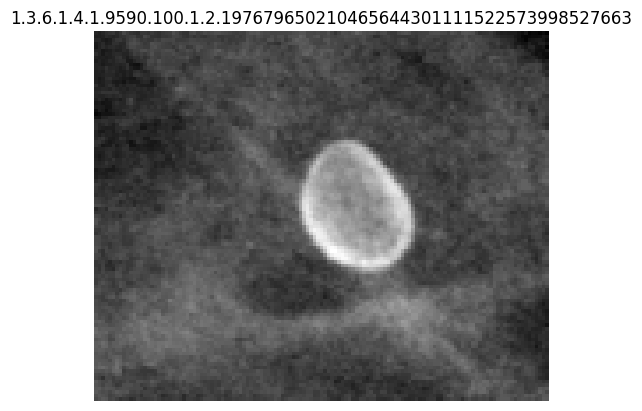


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Mass-Training_P_01844_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.34626139911214246732007187202875218197/1.3.6.1.4.1.9590.100.1.2.343415346312123544113551650783871288016/1-2.dcm


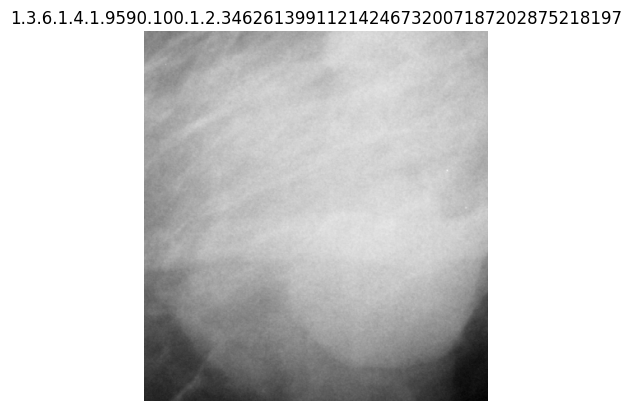


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Mass-Training_P_01844_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.34626139911214246732007187202875218197/1.3.6.1.4.1.9590.100.1.2.343415346312123544113551650783871288016/1-1.dcm


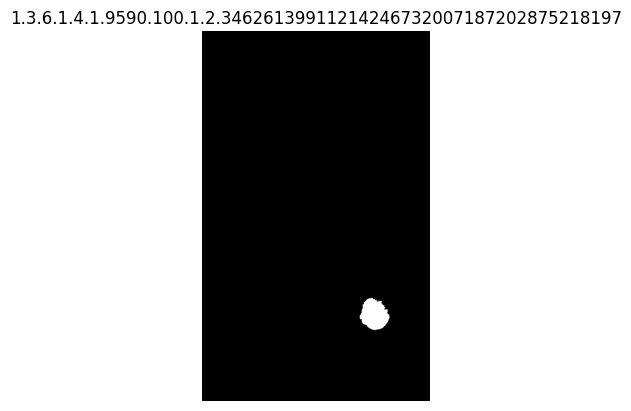


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Mass-Training_P_00703_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.332944262311909489515510672722545761997/1.3.6.1.4.1.9590.100.1.2.202675500012341890639589579582926153492/1-1.dcm


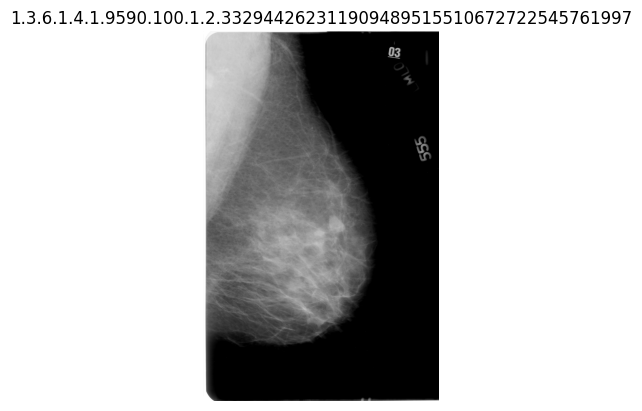


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Mass-Test_P_01566_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.234616849311382925724833783352722668501/1.3.6.1.4.1.9590.100.1.2.164750739813549290437512567251665770245/1-1.dcm


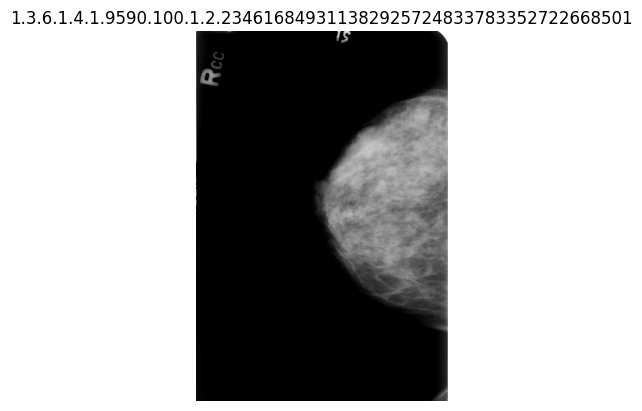


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Calc-Training_P_00967_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.247404762613756277324507644551469768045/1.3.6.1.4.1.9590.100.1.2.83339404912524474831713499070934405979/1-2.dcm


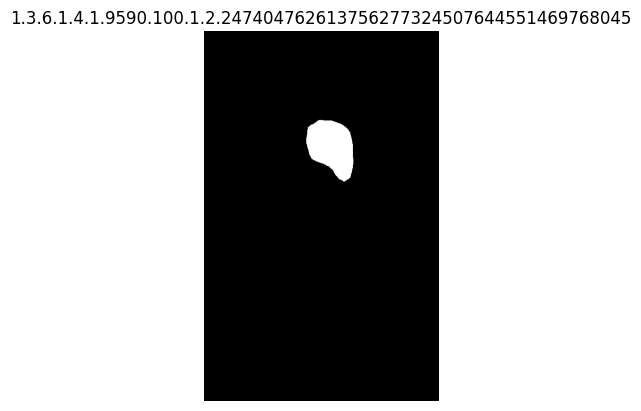


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Calc-Training_P_00967_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.247404762613756277324507644551469768045/1.3.6.1.4.1.9590.100.1.2.83339404912524474831713499070934405979/1-1.dcm


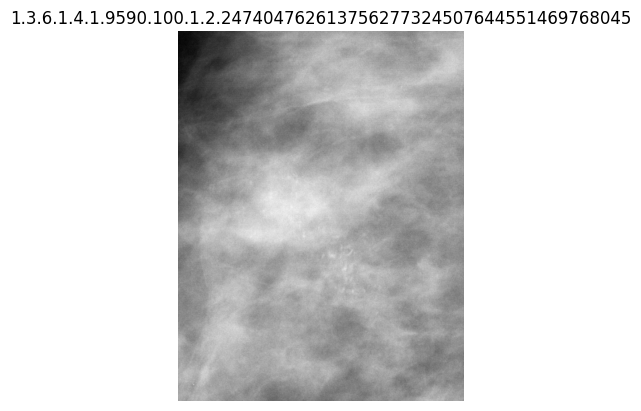


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Calc-Training_P_01885_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.411936919211703316006492415023219952613/1.3.6.1.4.1.9590.100.1.2.412805349511988982041074955902270862072/1-1.dcm


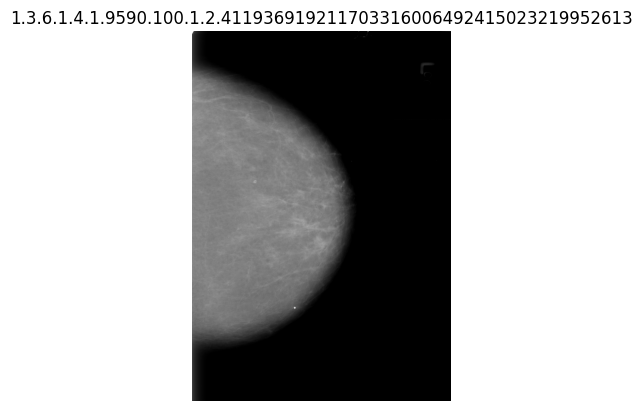


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Calc-Training_P_02393_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.414450452112276708226385394091284430169/1.3.6.1.4.1.9590.100.1.2.284464123012025065005317272673765215147/1-2.dcm


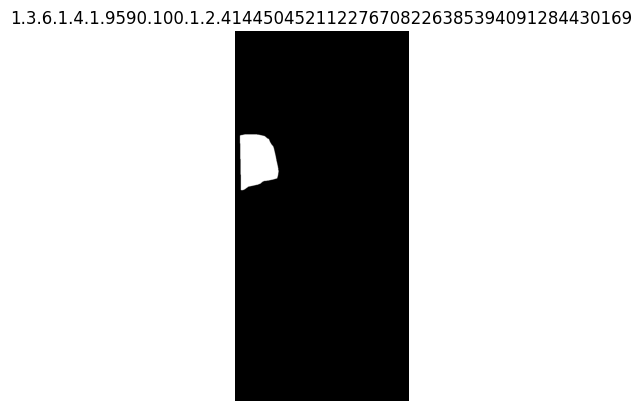

In [18]:
import os
import glob
import pydicom
import matplotlib.pyplot as plt

# Ruta base
base_path = '/Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM'

# Buscar todos los archivos .dcm de forma recursiva
dcm_files = glob.glob(os.path.join(base_path, "**", "*.dcm"), recursive=True)

# Verificar y mostrar la primera imagen
if dcm_files:
    example_path = dcm_files[0]
    print("Archivo encontrado:", example_path)

    dicom = pydicom.dcmread(example_path)
    plt.imshow(dicom.pixel_array, cmap='gray')
    plt.title("Imagen DICOM encontrada automáticamente")
    plt.axis('off')
    plt.show()
else:
    print("No se encontró ningún archivo DICOM en el dataset")

# Mostrar las primeras 10 imágenes del dataset
for path in dcm_files[:10]:
    print("\nMostrando:", path)
    dicom = pydicom.dcmread(path)
    plt.imshow(dicom.pixel_array, cmap='gray')
    plt.title(path.split("/")[-3])
    plt.axis('off')
    plt.show()

### Escalado de los datos con `StandardScaler`

Este paso aplica una transformación de escalado a las variables predictoras (`X_train`, `X_val`, `X_test`) utilizando `StandardScaler`, una técnica fundamental cuando se entrena un modelo SVM.

**Importancia:**
- El modelo SVM es muy sensible a las diferencias de escala entre variables.
- `StandardScaler` convierte cada feature a una distribución con media 0 y desviación estándar 1.
- Esto evita que features con valores grandes (como `width` o `height`) dominen el modelo.

Se entrena el `scaler` solo con los datos de entrenamiento (`fit_transform`) y luego se aplica la misma transformación a validación y test (`transform`), garantizando un flujo limpio y sin fuga de información.


In [19]:
# Escalado de los datos antes de entrenar el modelo
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Entrenamiento del Modelo SVM

### Optimización de hiperparámetros del modelo SVM con GridSearchCV

En este bloque se realiza una búsqueda exhaustiva de la mejor combinación de hiperparámetros del modelo SVM mediante `GridSearchCV`.

Se emplea validación cruzada estratificada (`StratifiedKFold`) para garantizar que cada pliegue respete la proporción de clases, y se evalúa el rendimiento usando la métrica `f1_weighted`, adecuada para clasificación multiclase desbalanceada.

El objetivo es seleccionar la combinación óptima de:

- `C`: penalización del margen
- `kernel`: tipo de núcleo (lineal, RBF, polinómico)
- `gamma`: parámetro del kernel
- `class_weight`: balanceo automático entre clases

Al finalizar, se entrena el mejor modelo encontrado sobre los datos escalados.


In [20]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

# Validación cruzada
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced']
}

# Búsqueda de mejor modelo
svc = SVC(probability=True)
grid = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

print(X_train_scaled,y_train)

grid.fit(X_train_scaled, y_train)

# Resultados
print("📌 Mejor combinación encontrada:")
print(grid.best_params_)
print(f"F1 ponderado en validación cruzada: {grid.best_score_:.4f}")

# Guardar mejor modelo
svm_model = grid.best_estimator_


[[ 1.09982582  0.15236014 -0.41657641 ... -0.17633592 -1.49367408
   0.24335329]
 [-0.35676666  0.03006303  1.52068321 ...  1.3715927   1.67697674
  -1.49418307]
 [ 0.35134946  0.15551388  0.6423873  ... -0.17633592 -0.43679047
   0.24335329]
 ...
 [ 1.52250327  1.21131383 -0.98898922 ... -0.17633592 -1.49367408
  -2.36295126]
 [-1.07499713 -1.02419807  1.38652396 ... -0.95030022 -0.43679047
   1.11212148]
 [-0.6151073  -0.04269504 -0.2019216  ...  0.59762839  0.62009314
  -0.62541489]] 0       1
1       2
2       1
3       1
4       1
       ..
2826    1
2827    1
2828    2
2829    1
2830    2
Name: pathology_label, Length: 2831, dtype: int64
Fitting 3 folds for each of 36 candidates, totalling 108 fits
📌 Mejor combinación encontrada:
{'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
F1 ponderado en validación cruzada: 0.7862


### Búsqueda de hiperparámetros (`GridSearchCV`)
Este bloque de código implementa una búsqueda exhaustiva sobre una rejilla de hiperparámetros del modelo `SVC` (Support Vector Classification), utilizando validación cruzada estratificada con 3 particiones. Evalúa distintas combinaciones de `C`, `kernel`, `gamma` y `class_weight` para optimizar la métrica F1 ponderada, y selecciona automáticamente el mejor clasificador.


In [21]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.422876,0.030032,0.119514,0.005319,0.1,None,scale,linear,"{'C': 0.1, 'class_weight': None, 'gamma': 'sca...",0.680730,0.668677,0.644629,0.664679,0.015007,31
1,2.666636,0.013397,0.498364,0.005987,0.1,None,scale,rbf,"{'C': 0.1, 'class_weight': None, 'gamma': 'sca...",0.708768,0.723456,0.705245,0.712490,0.007887,17
2,1.967334,0.009880,0.167543,0.011257,0.1,None,scale,poly,"{'C': 0.1, 'class_weight': None, 'gamma': 'sca...",0.681045,0.691255,0.708431,0.693577,0.011300,22
3,1.281958,0.020771,0.109434,0.001882,0.1,None,auto,linear,"{'C': 0.1, 'class_weight': None, 'gamma': 'aut...",0.680730,0.668677,0.644629,0.664679,0.015007,31
4,2.639943,0.030441,0.459406,0.007339,0.1,None,auto,rbf,"{'C': 0.1, 'class_weight': None, 'gamma': 'aut...",0.708768,0.722235,0.704353,0.711785,0.007606,18
5,2.056335,0.025953,0.164977,0.012374,0.1,None,auto,poly,"{'C': 0.1, 'class_weight': None, 'gamma': 'aut...",0.681045,0.689430,0.710439,0.693638,0.012363,21
6,1.481189,0.043315,0.115459,0.002345,0.1,balanced,scale,linear,"{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",0.672981,0.665945,0.639570,0.659499,0.014382,35
7,2.980160,0.076442,0.557616,0.024442,0.1,balanced,scale,rbf,"{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",0.707472,0.713658,0.705082,0.708737,0.003613,20
8,2.276689,0.059547,0.214959,0.012080,0.1,balanced,scale,poly,"{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",0.663185,0.688653,0.717322,0.689720,0.022114,23
9,1.426912,0.024370,0.130060,0.020408,0.1,balanced,auto,linear,"{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",0.672981,0.665945,0.639570,0.659499,0.014382,35


### Evaluación del Modelo


 Evaluación sobre Entrenamiento (Train):



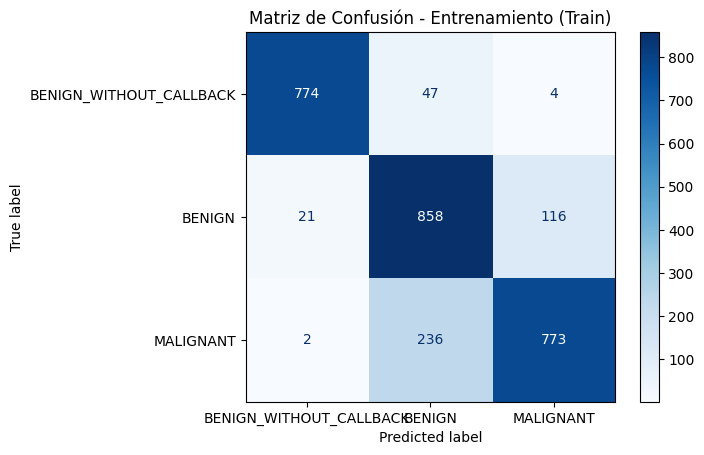

Reporte de Clasificación:
                         precision    recall  f1-score   support

BENIGN_WITHOUT_CALLBACK       0.97      0.94      0.95       825
                 BENIGN       0.75      0.86      0.80       995
              MALIGNANT       0.87      0.76      0.81      1011

               accuracy                           0.85      2831
              macro avg       0.86      0.86      0.86      2831
           weighted avg       0.86      0.85      0.85      2831

Accuracy en Entrenamiento (Train): 0.8495

 Evaluación sobre Validación (Val):



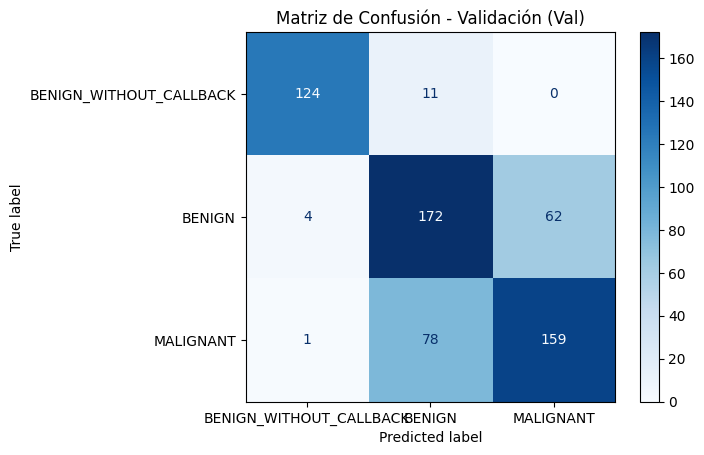

Reporte de Clasificación:
                         precision    recall  f1-score   support

BENIGN_WITHOUT_CALLBACK       0.96      0.92      0.94       135
                 BENIGN       0.66      0.72      0.69       238
              MALIGNANT       0.72      0.67      0.69       238

               accuracy                           0.74       611
              macro avg       0.78      0.77      0.77       611
           weighted avg       0.75      0.74      0.75       611

Accuracy en Validación (Val): 0.7447

 Evaluación sobre Test:



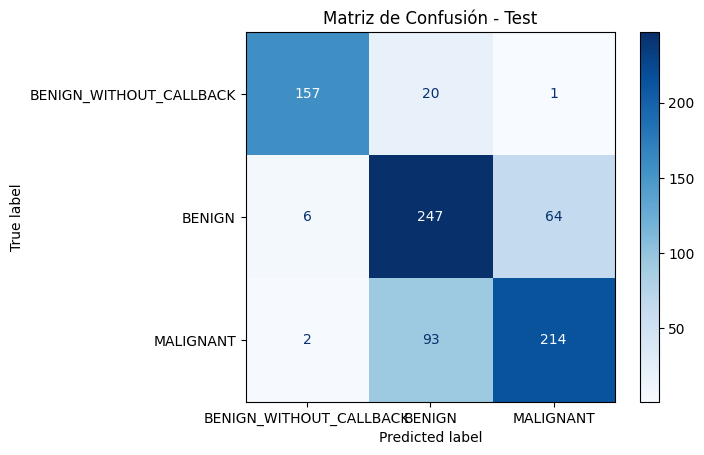

Reporte de Clasificación:
                         precision    recall  f1-score   support

BENIGN_WITHOUT_CALLBACK       0.95      0.88      0.92       178
                 BENIGN       0.69      0.78      0.73       317
              MALIGNANT       0.77      0.69      0.73       309

               accuracy                           0.77       804
              macro avg       0.80      0.78      0.79       804
           weighted avg       0.78      0.77      0.77       804

Accuracy en Test: 0.7687


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Etiquetas originales según el orden de codificación
label_names = ['BENIGN_WITHOUT_CALLBACK', 'BENIGN', 'MALIGNANT']

# Diccionario con datos escalados para evaluar
eval_sets = {
    'Entrenamiento (Train)': (X_train_scaled, y_train),
    'Validación (Val)': (X_val_scaled, y_val),
    'Test': (X_test_scaled, y_test)
}

# Evaluar modelo sobre cada conjunto
for nombre, (X_set, y_true) in eval_sets.items():
    print(f"\n Evaluación sobre {nombre}:\n")

    y_pred = svm_model.predict(X_set)

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap='Blues')
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.grid(False)
    plt.show()

    # Reporte de clasificación
    print("Reporte de Clasificación:")
    print(classification_report(y_true, y_pred, target_names=label_names))

    # Accuracy simple
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy en {nombre}: {accuracy:.4f}")

| Métrica       | Significado                                 | Qué representa                                               | Rango típico | Qué indica                        |
| ------------- | ------------------------------------------- | ------------------------------------------------------------ | ------------ | --------------------------------- |
| **Accuracy**  | Precisión global                            | % de predicciones correctas sobre el total                   | 0 a 1        | Qué tan bien clasifica en general |
| **Precision** | Precisión positiva                          | % de aciertos entre los que el modelo predijo como positivos | 0 a 1        | Minimiza falsos positivos (FP)    |
| **Recall**    | Sensibilidad o Tasa de verdaderos positivos | % de casos positivos correctamente detectados                | 0 a 1        | Minimiza falsos negativos (FN)    |
| **F1-score**  | Media armónica entre precision y recall     | Combina precisión y sensibilidad                             | 0 a 1        | Equilibrio entre FP y FN          |



In [17]:
import sys
!{sys.executable} -m pip install shap

zsh:1: no matches found: (Trabajo de Fin de Master)/notebooks/tfm_env/bin/python


### Explicabilidad por clase con SHAP (summary plots)

En este bloque se utiliza la técnica SHAP (SHapley Additive exPlanations) con `KernelExplainer` para analizar cómo influye cada característica en la predicción **por clase** del modelo SVM.

- Se usa la función `predict_proba()` para obtener las probabilidades de cada clase.
- Se construye un explicador SHAP independiente para cada clase (`BENIGN_WITHOUT_CALLBACK`, `BENIGN`, `MALIGNANT`).
- El background se resume usando `KMeans` sobre los datos de entrenamiento escalados.
- Se genera un `summary_plot` por clase que muestra cómo contribuyen las variables a aumentar o disminuir la probabilidad de pertenencia a esa clase.

Esto permite entender el modelo de forma **global** para cada clase, lo cual es especialmente útil en clasificación multiclase con desequilibrios.



/Users/clubability/Documents/Maestria/TFM (Trabajo de Fin de Master)/notebooks/tfm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



 SHAP para clase 0 → BENIGN_WITHOUT_CALLBACK


100%|███████████████████████████████████████████| 50/50 [00:07<00:00,  6.82it/s]


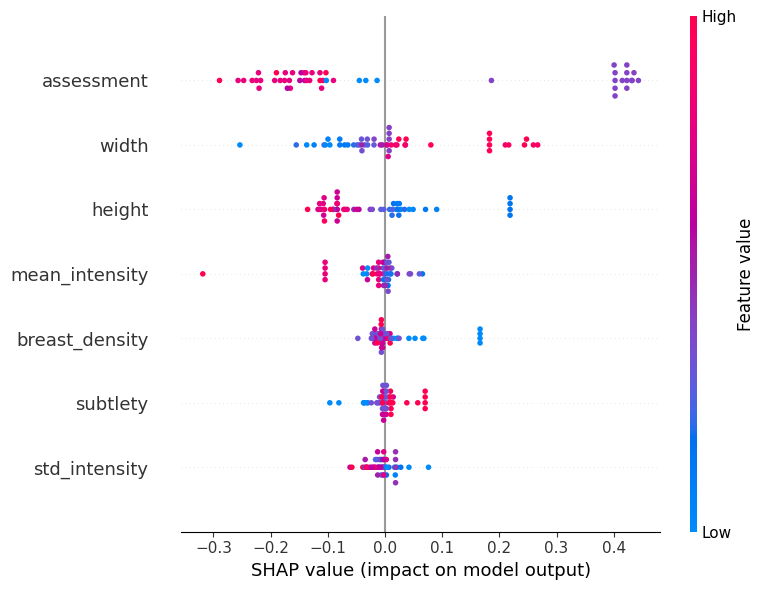


 SHAP para clase 1 → BENIGN


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  7.18it/s]


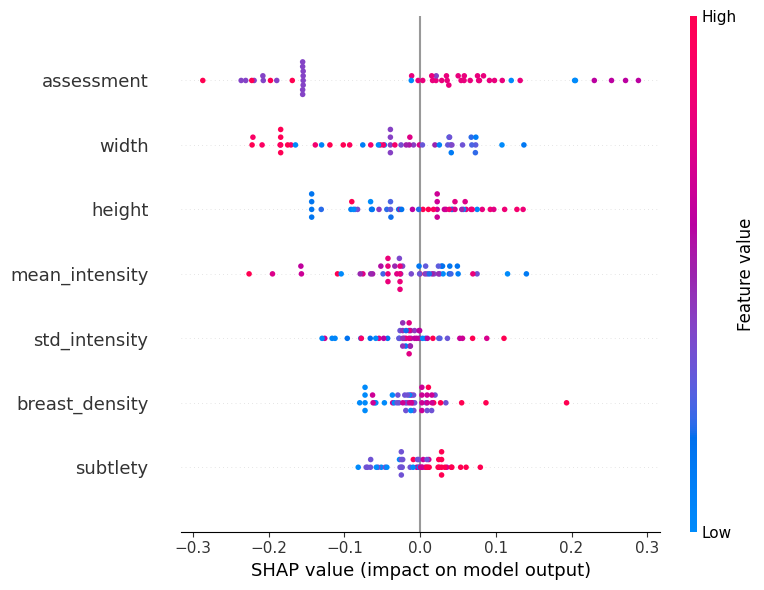


 SHAP para clase 2 → MALIGNANT


100%|███████████████████████████████████████████| 50/50 [00:07<00:00,  6.39it/s]


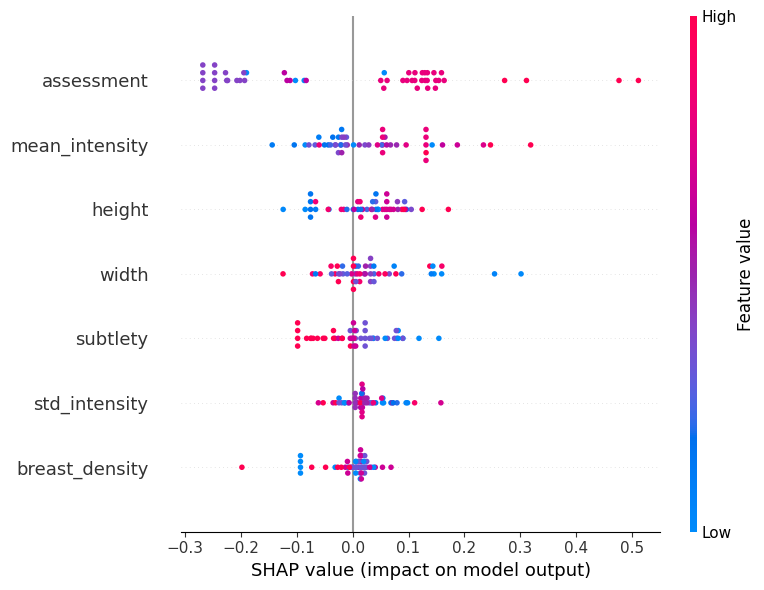

In [18]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Lista de features usados en el modelo
features_usar = [
    "mean_intensity", "std_intensity", "width", "height",
    "assessment", "breast_density", "subtlety"
]

# Convertimos X_sample a DataFrame con nombres
X_sample = X_val_scaled[:50]
X_sample_df = pd.DataFrame(X_sample, columns=features_usar)

# Background con KMeans (como resumen representativo del entrenamiento)
background = KMeans(n_clusters=10, random_state=42).fit(X_train_scaled).cluster_centers_

# Obtener probabilidades por clase
# predict_proba devuelve shape (n_samples, n_classes)
predict_proba = svm_model.predict_proba

# Etiquetas de clase según orden de codificación
clases = ['BENIGN_WITHOUT_CALLBACK', 'BENIGN', 'MALIGNANT']

# Repetimos para cada clase
for i, clase in enumerate(clases):
    print(f"\n SHAP para clase {i} → {clase}")

    # Función que devuelve solo la probabilidad de la clase i
    def prob_clase_i(X):
        return predict_proba(X)[:, i]

    # Crear un nuevo explicador SHAP solo para esa clase
    explainer_i = shap.KernelExplainer(prob_clase_i, background)

    # Calcular valores SHAP solo para esa clase
    shap_values_i = explainer_i.shap_values(X_sample)

    # Visualizar el resumen para esa clase
    shap.summary_plot(shap_values_i, X_sample_df, feature_names=features_usar, plot_size=(8, 6))



### Interpretación individual con gráfico tipo Waterfall (SHAP)

Este gráfico muestra cómo cada una de las 7 características contribuye a la predicción final del modelo SVM para una observación específica del conjunto de test.

- `E[f(X)]` representa el valor promedio de predicción del modelo para la clase seleccionada (en este caso, clase `i = 2` → *MALIGNANT*).
- `f(x)` es la predicción final para la muestra analizada.
- Cada barra muestra cuánto influye una característica específica para acercarse o alejarse del valor promedio:
  - 🔴 Barras rojas: contribuyen **positivamente** a aumentar la probabilidad de la clase.
  - 🔵 Barras azules: contribuyen **negativamente**, reduciendo la probabilidad.
  
Este tipo de explicabilidad es especialmente útil en contextos clínicos, donde es necesario justificar por qué el modelo ha clasificado un caso como *maligno* o *benigno* según sus valores individuales.


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.69it/s]


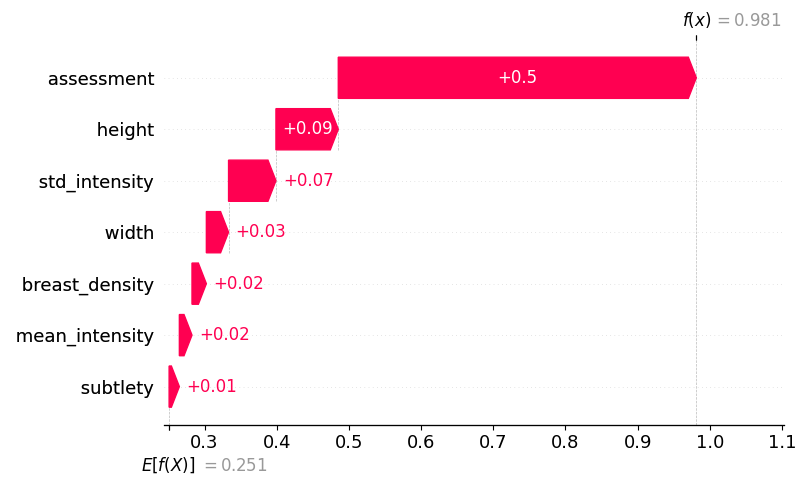

In [19]:
import shap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd

# Lista de features usados
features_usar = [
    "mean_intensity", "std_intensity", "width", "height",
    "assessment", "breast_density", "subtlety"
]

# Background para SHAP (resumen del entrenamiento)
background = KMeans(n_clusters=10, random_state=42).fit(X_train_scaled).cluster_centers_

# Convertir X_test_scaled en DataFrame
X_test_df = pd.DataFrame(X_test_scaled, columns=features_usar)

# Seleccionamos una observación específica
i_obs = 5  # puedes cambiar este índice a cualquier muestra
x_explicar = X_test_scaled[i_obs:i_obs+1]

# Elegir clase a explicar (0, 1 o 2)
i_clase = 2  # por ejemplo: 2 = MALIGNANT

# Crear función que devuelve solo probabilidad de esa clase
def predict_clase_i(X):
    return svm_model.predict_proba(X)[:, i_clase]

# Crear el explicador para esa clase
explainer = shap.KernelExplainer(predict_clase_i, background)

# Obtener valores SHAP para esa muestra
shap_values = explainer.shap_values(x_explicar)

# Visualizar con waterfall
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[0],         # como es una sola muestra
    X_test_df.iloc[i_obs],  # los valores de entrada originales
    feature_names=features_usar
)

### Evaluación del modelo SVM con curvas ROC por clase

En esta sección se calcula y visualiza la curva ROC (Receiver Operating Characteristic) para cada una de las tres clases objetivo del modelo SVM:  
`BENIGN_WITHOUT_CALLBACK`, `BENIGN` y `MALIGNANT`.

Para ello:

- Se binarizan las etiquetas (`one-vs-rest`) mediante `label_binarize`.
- Se utiliza la salida cruda del modelo (`decision_function`) como score.
- Se calcula el **Área Bajo la Curva (AUC)** para cada clase por separado.
- Se genera la curva ROC correspondiente a cada clase junto con una línea base aleatoria.
- Se calcula también el **AUC macro promedio**, que evalúa el rendimiento general del modelo multiclase sin ponderación.

Este análisis permite evaluar la capacidad del modelo para distinguir entre clases más allá de la simple precisión, especialmente útil en contextos médicos donde los falsos positivos y negativos tienen distinto impacto.


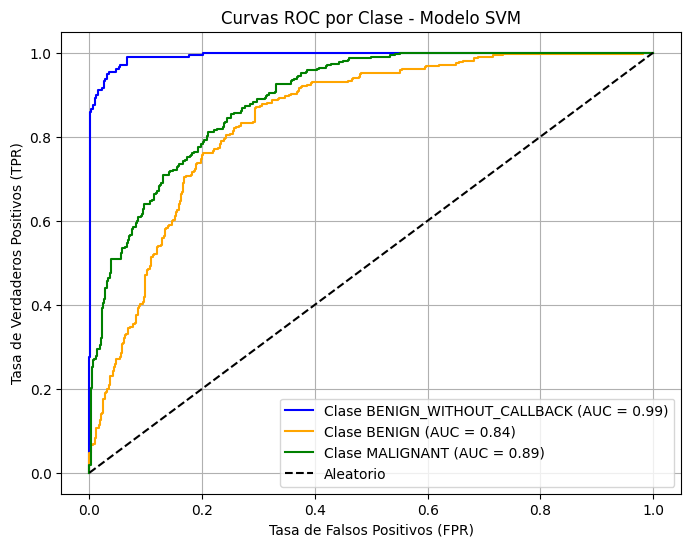

AUC macro promedio: 0.9105


In [20]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Etiquetas de clase en orden de codificación
clases = ['BENIGN_WITHOUT_CALLBACK', 'BENIGN', 'MALIGNANT']

# Binarizar las etiquetas para one-vs-rest
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Obtener scores del modelo (logits)
y_score = svm_model.decision_function(X_test_scaled)

# Calcular curvas ROC y AUC por clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro promedio
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

# Visualización
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f"Clase {clases[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.title("Curvas ROC por Clase - Modelo SVM")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# AUC macro
print(f"AUC macro promedio: {macro_auc:.4f}")



### Guardado del Modelo SVM Optimizado y del GridSearchCV Completo

En esta sección se guardan dos versiones del modelo entrenado:

1. **Modelo final (`svm_model_final.pkl`)**  
   Contiene únicamente el mejor modelo entrenado (`SVC`) con los hiperparámetros óptimos.  
   Es ideal para:
   - Realizar predicciones rápidamente
   - Aplicar interpretabilidad (SHAP, curvas ROC, etc.)
   - Usar en producción

2. **GridSearchCV completo (`svm_grid.pkl`)**  
   Contiene todo el objeto de búsqueda, incluyendo:
   - Todas las combinaciones de hiperparámetros evaluadas
   - Resultados de validación cruzada (`cv_results_`)
   - Acceso al mejor modelo (`best_estimator_`)

Este enfoque permite mantener un modelo liviano para uso práctico, sin perder acceso a los metadatos del proceso de optimización, lo cual es muy útil para documentación o mejora futura.




In [23]:
import os
import joblib

# Crear carpeta si no existe
ruta_directorio_modelo = '/Users/clubability/Documents/Dataset_TFM/modelos'
os.makedirs(ruta_directorio_modelo, exist_ok=True)

# Ruta 1: modelo final optimizado
ruta_modelo_final = os.path.join(ruta_directorio_modelo, 'svm_model_final.pkl')
joblib.dump(svm_model, ruta_modelo_final)  # aquí guardas best_estimator_

# Ruta 2: GridSearchCV completo
ruta_grid = os.path.join(ruta_directorio_modelo, 'svm_grid.pkl')
joblib.dump(grid, ruta_grid)  # aquí guardas el objeto GridSearchCV completo

print(f"- Modelo final guardado en: {ruta_modelo_final}")
print(f"- GridSearchCV completo guardado en: {ruta_grid}")

- Modelo final guardado en: /Users/clubability/Documents/Dataset_TFM/modelos/svm_model_final.pkl
- GridSearchCV completo guardado en: /Users/clubability/Documents/Dataset_TFM/modelos/svm_grid.pkl


In [24]:
# Cargar solo el modelo listo para predicción
modelo_final = joblib.load(ruta_modelo_final)

# Cargar el grid completo para ver resultados
grid_completo = joblib.load(ruta_grid)
# Mostrar los mejores hiperparámetros encontrados por GridSearchCV
print("Mejores hiperparámetros:", grid_completo.best_params_)

Mejores hiperparámetros: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
